# Eurovision Jury Vote Forecast - Exploratory Data Analysis

**Goal:** Understanding jury voting patterns before any modelling.

This notebook covers four analytical areas:

1. Jury vote distribution per year.
2. Jury genoristy (average points given)
3. Strong bilateral relationships (A -> B)
4. Stability over time (year to year correlations)

All data is loaded via the `eurojury` package.

## 0. Setup & Imports

In [1]:
import sys
import warnings

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns

# make eurojury importable when running from notebooks/
sys.path.append("../src")
from eurojury import load

warnings.filterwarnings("ignore")

# global plot style
sns.set_theme(style= "whitegrid", palette= "muted", font_scale= 1.1)
plt.rcParams["figure.dpi"] = 120

In [2]:
# load all available years
df = load()

print(f"Shape		: {df.shape}")
print(f"Years		: {sorted(df['year'].unique())}")
print(f"Juries		: {df['jury_iso'].nunique()}")
df.head()

Shape		: (8999, 6)
Years		: [np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Juries		: 45


,performer_country,jury_country,jury_points,year,performer_iso,jury_iso
0,Belgium,Austria,5,2016,BEL,AUT
1,Czech Republic,Austria,4,2016,CZE,AUT
2,Netherlands,Austria,0,2016,NLD,AUT
3,Azerbaijan,Austria,0,2016,AZE,AUT
4,Hungary,Austria,0,2016,HUN,AUT


---
## 1. Jury Vote Distribution Per Year

**Question:** How are jury points distributed across years? Are there structuraş differences (e.g. nomber of competing countries) between editions?

In [3]:
# number of juries and performers per year
year_stats = (
	df.groupby("year")
	.agg(
		n_juries= ("jury_iso", "nunique"),
		n_performers= ("performer_iso", "nunique"),
		total_points= ("jury_points", "sum")
	)
	.reset_index()
)
year_stats

,year,n_juries,n_performers,total_points
0,2016,42,26,2436
1,2017,42,26,2436
2,2018,43,26,2494
3,2019,41,26,2378
4,2021,39,26,2262
5,2022,40,25,2320
6,2023,37,26,2146
7,2024,37,25,2146
8,2025,37,26,2146


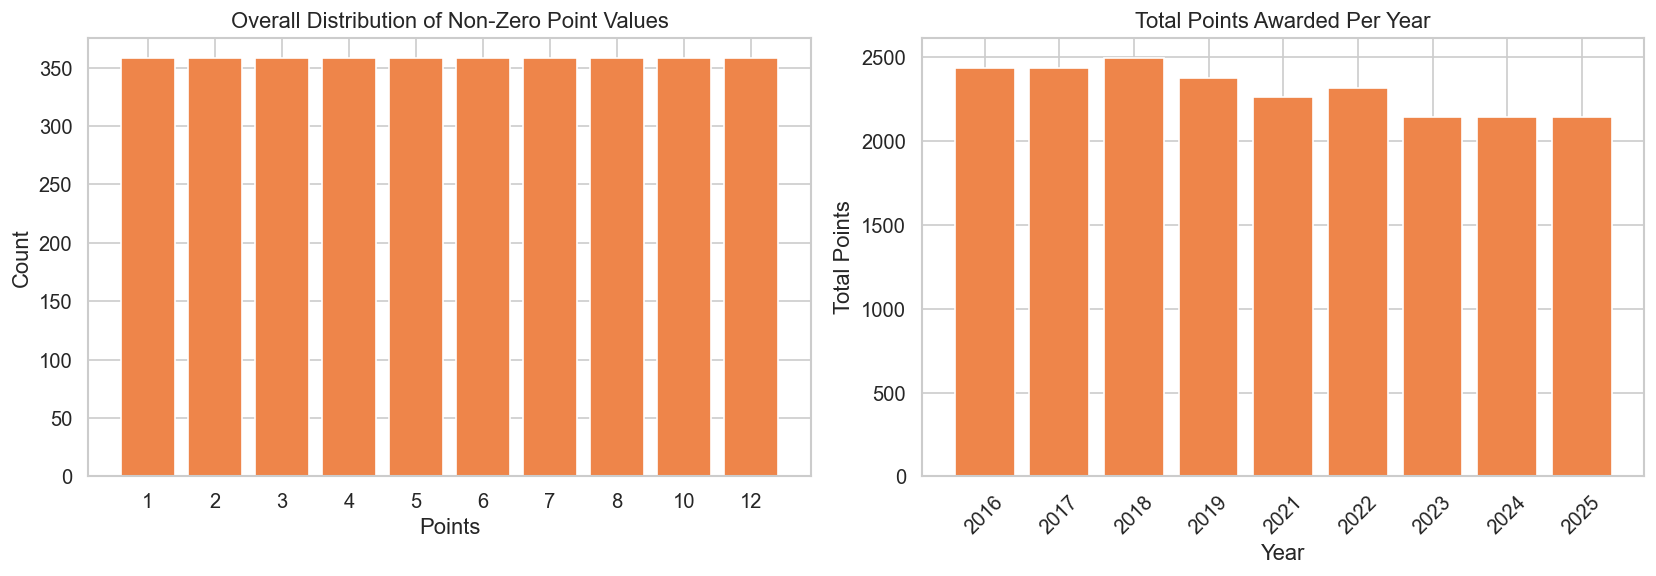

In [4]:
# distribution of non-zero point values across all years
nonzero = df[df['jury_points'] > 0]

fig, axes = plt.subplots(1, 2, figsize= (14, 5))

# left: count of each point value overall
point_counts = nonzero['jury_points'].value_counts().sort_index()
axes[0].bar(point_counts.index.astype(str), point_counts.values, color= sns.color_palette("muted")[1])
axes[0].set_title("Overall Distribution of Non-Zero Point Values")
axes[0].set_xlabel("Points")
axes[0].set_ylabel("Count")

# right: total points awarded per year
axes[1].bar(year_stats['year'].astype(str), year_stats['total_points'], color= sns.color_palette("muted")[1])
axes[1].set_title("Total Points Awarded Per Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Total Points")
axes[1].tick_params(axis= "x", rotation= 45)

plt.tight_layout()
plt.show()

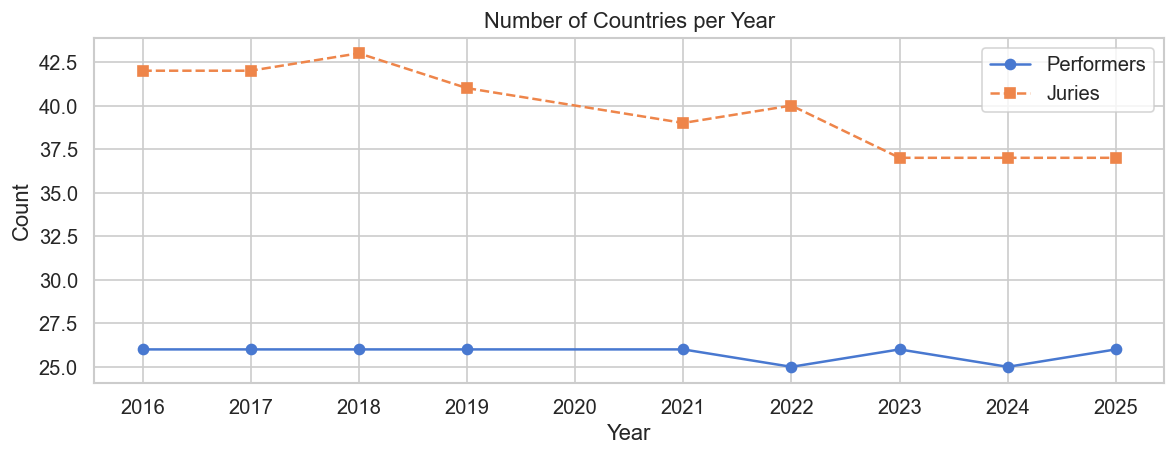

In [5]:
# number of competing countries per year
fig, ax = plt.subplots(figsize= (10, 4))

ax.plot(year_stats['year'], year_stats['n_performers'], marker= "o", label= "Performers")
ax.plot(year_stats['year'], year_stats['n_juries'], marker= "s", linestyle= "--", label= "Juries")
ax.set_title("Number of Countries per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer= True))
ax.legend()
plt.tight_layout()
plt.show()

**Observations:**

- Point value distribution is perfectly uniform (~355 per value) - rules are consistently enforced across all years.

- Total points decline over time purely due to a shrinking jury pool (43 to 37), not rule changes.

- Performer count is stable at 25-26, meaning the ranking task has a consisten output space throughout.

- 2020 is absent as expected (COVID cancellation).

---
## 2. Jury Generosity

**Question:** Do some juries consistently award more points on average? This could reveal systematic bias in voting behaviour?

In [6]:
# average points given by each jury (all years, all rows including zeros)
generosity = (
	df.groupby("jury_iso")['jury_points']
	.mean()
	.sort_values(ascending= False)
	.reset_index()
	.rename(columns= {"jury_points": "avg_points_given"})
)
generosity.head(10)

,jury_iso,avg_points_given
0,LUX,2.367347
1,UKR,2.343434
2,FRA,2.340807
3,GBR,2.340807
4,SWE,2.340807
5,ITA,2.340807
6,DEU,2.340807
7,ESP,2.340807
8,PRT,2.331658
9,NOR,2.330357


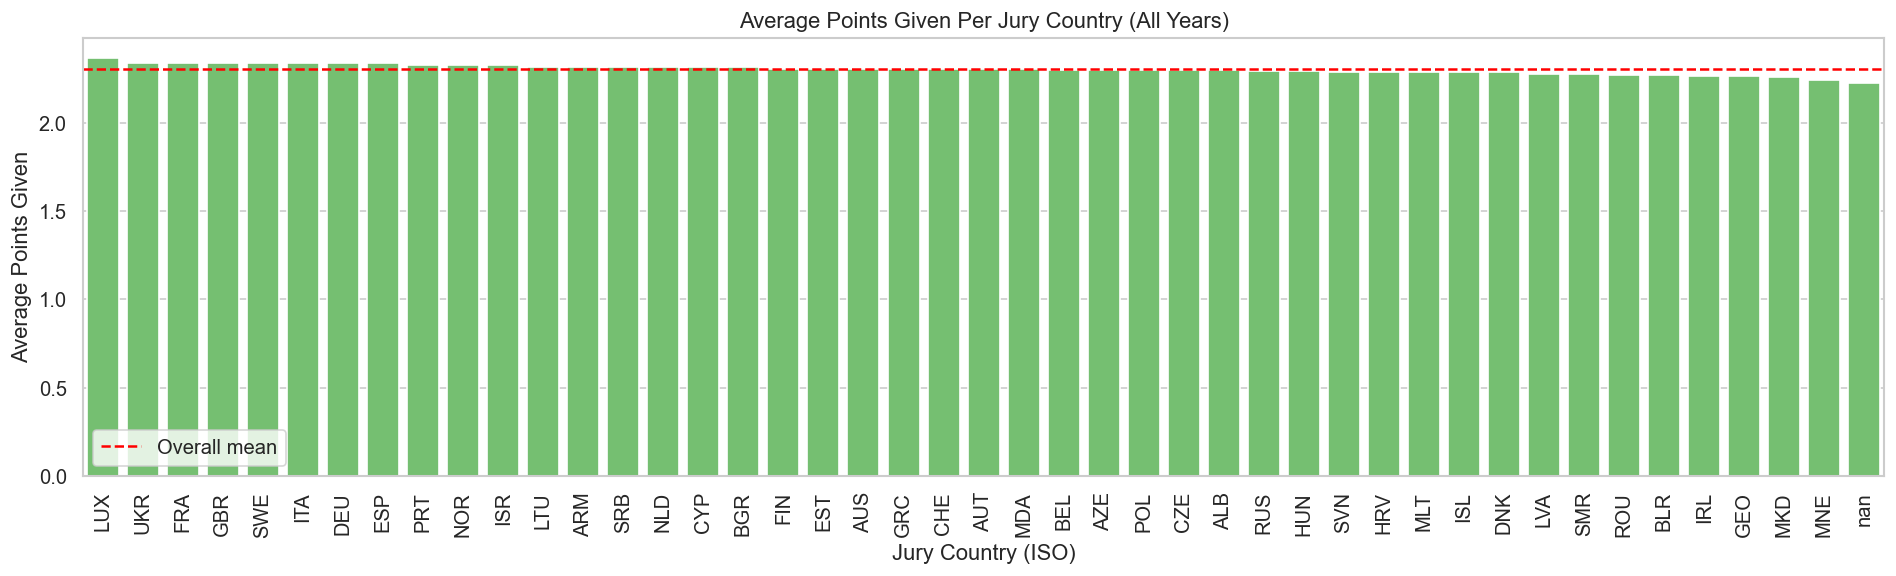

In [7]:
fig, ax = plt.subplots(figsize= (16, 5))

sns.barplot(
	data= generosity,
	x= "jury_iso",
	y= "avg_points_given",
	order= generosity['jury_iso'],
	ax= ax,
	color= sns.color_palette("muted")[2],
)

ax.axhline(generosity['avg_points_given'].mean(), color= "red", linestyle= "--", label= "Overall mean")
ax.set_title("Average Points Given Per Jury Country (All Years)")
ax.set_xlabel("Jury Country (ISO)")
ax.set_ylabel("Average Points Given")
ax.tick_params(axis= "x", rotation= 90)
ax.legend()
plt.tight_layout()
plt.show()

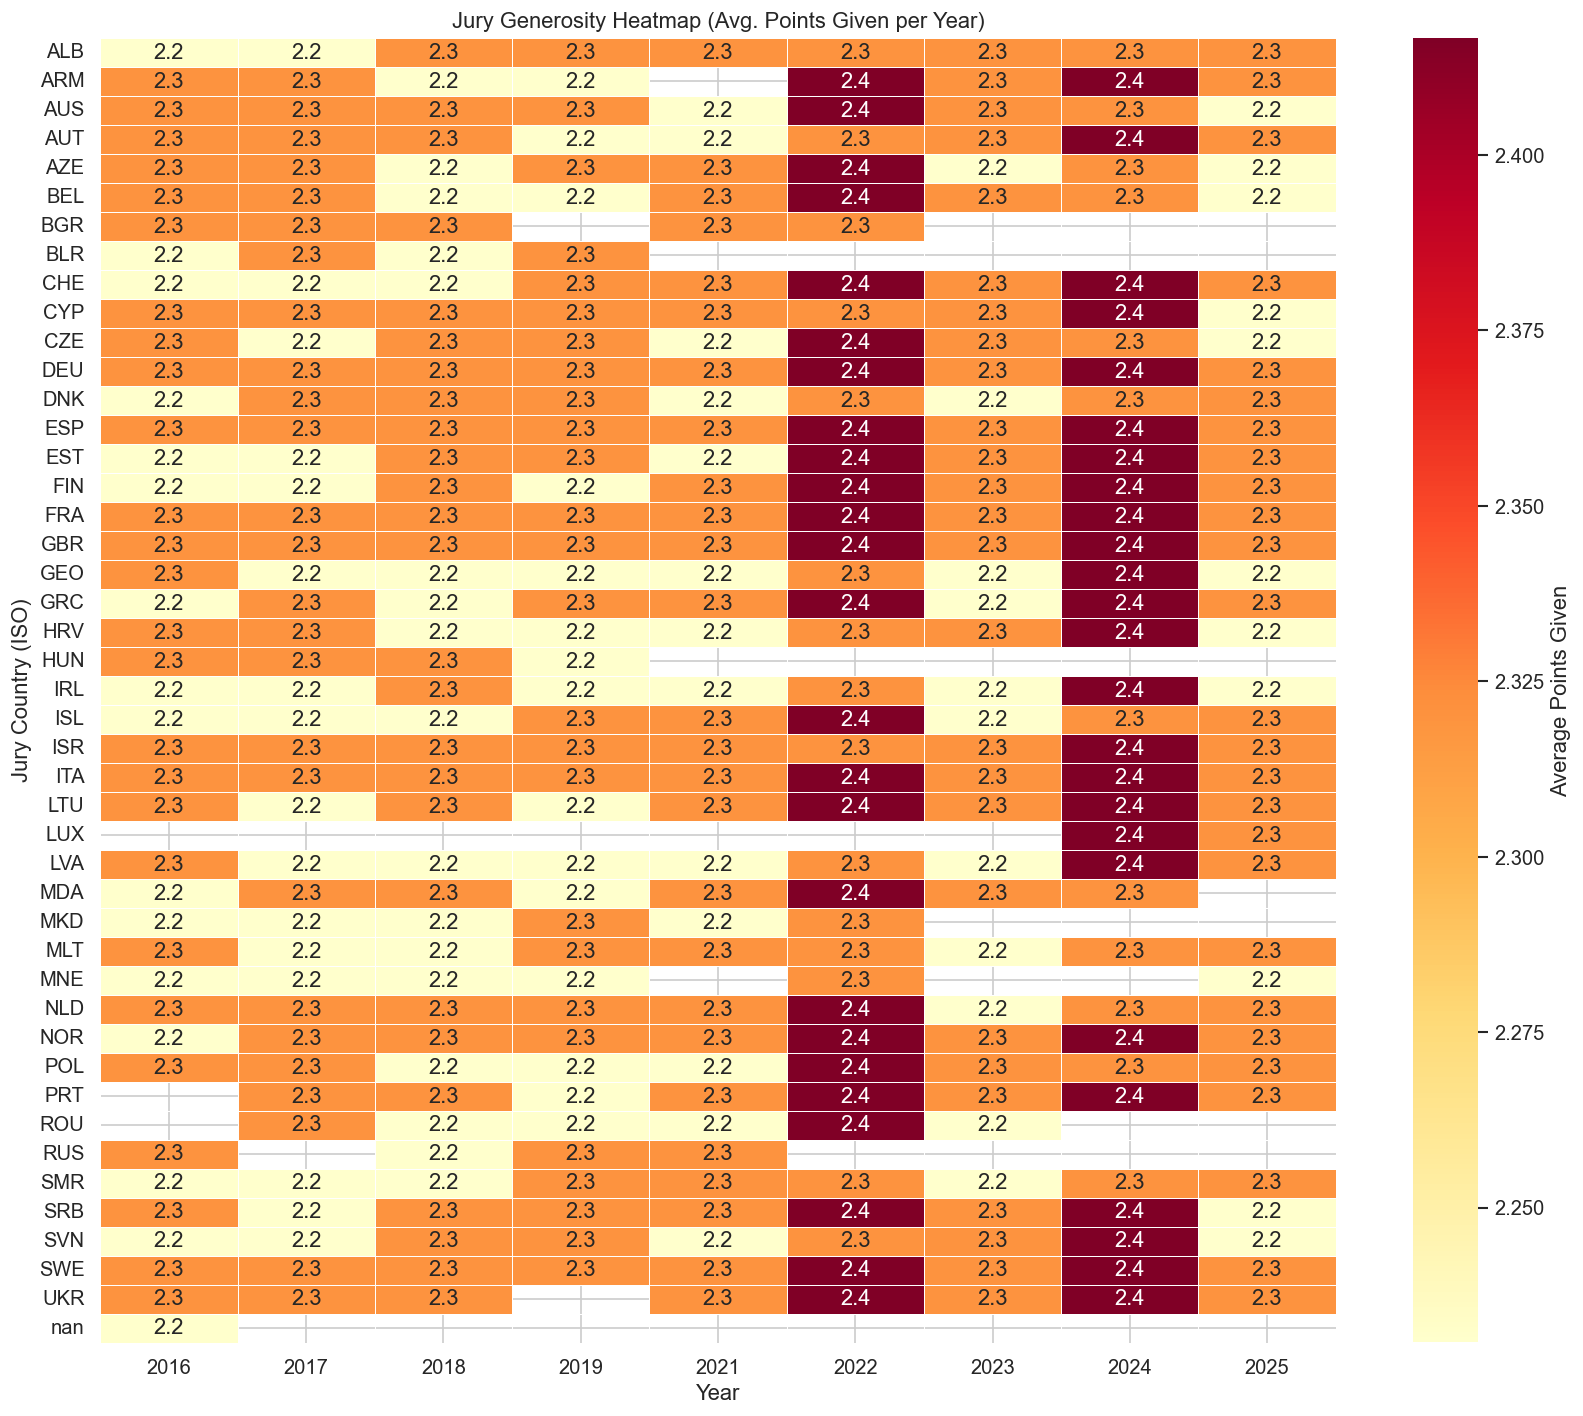

In [8]:
# generosity over time: heatmap (jury x year)
generosity_pivot = (
	df.groupby(["jury_iso", "year"])['jury_points']
	.mean()
	.unstack("year")
)

fig, ax = plt.subplots(figsize= (14, 12))
sns.heatmap(
	generosity_pivot,
	ax= ax,
	cmap= "YlOrRd",
	linewidths= 0.4,
	annot= True,
	fmt= ".1f",
	cbar_kws= {"label": "Average Points Given"}
)

ax.set_title("Jury Generosity Heatmap (Avg. Points Given per Year)")
ax.set_xlabel("Year")
ax.set_ylabel("Jury Country (ISO)")
plt.tight_layout()
plt.show()

**Observations:**

- Generosity differences between juries are negligible - all averages cluster tightly between 2.2 and 2.4. This is mathematically inevitable since every jury awards exactly 58 points across the same number of performers.

- LUX appears as an outlier in the bar chart, but this is misleading - Luxembourg only participated in 2024 and 2025, so its average is based on very few observations.

- The heatmap reveals a `NaN` entry, suggesting at least one row with a missing jury ISO value slipped through.

- 2022 consistently shows darker cells across nearly all juries - slightly higher averages that year, likely due to one fewer performer (25 vs 26), meaning 58 points spread over fewer rows raises the per-row mean.

---
## 3. Strong Bilateral Relationships (A -> B)

**Question:** Are there persistent pairs where jury A consistently awards high points to performer B?

These are the "friendship blocs" often discussed in Eurovision commentary.

In [9]:
# average points for each jury -> performer pair across all years
bilateral = (
	df.groupby(["jury_iso", "performer_iso"])['jury_points']
	.mean()
	.reset_index()
	.rename(columns= {"jury_points": "avg_points"})
	.sort_values("avg_points", ascending= False)
)

print("Top 15 strongest bilateral relationships:")
bilateral.head(15)

Top 15 strongest bilateral relationships:


,jury_iso,performer_iso,avg_points
1852,nan,UKR,12.000000
1606,RUS,MDA,12.000000
740,GBR,MKD,12.000000
29,ALB,MKD,12.000000
204,AZE,RUS,12.000000
1579,RUS,ARM,12.000000
1232,MDA,MKD,12.000000
362,CHE,MKD,12.000000
1690,SRB,MKD,12.000000
155,AUT,MKD,12.000000


**On the top bilateral averages:**

- Most 12.0 averages in the top pairs are based on a single year of data, making them statistically meaningless as predictors.

- Several pairs involve countries with very limited participation: North Makedonia (MKD) only reached the final once (2019), NaN appeared only in 2016, Russia and Belarus have been banned since 2022.

- Azerbaijan/Russia pair (12.0) is an exception - Azerbaijan gave Russia 12 points in all three years Russia reached the final (2016, 2019, 2021), making this a genuinely consistent political bloc. However, since Russia is banned, this pair has no predictive value going forward.

- The other genuinely informative pair in this table is Cyprus/Greece (11.17), which is backed by multiple years of consistently high scores.

**Conclusion:** Average points alone is a poor signal without controlling for sample size. The consistency table is far more reliable basis for feature engineering.

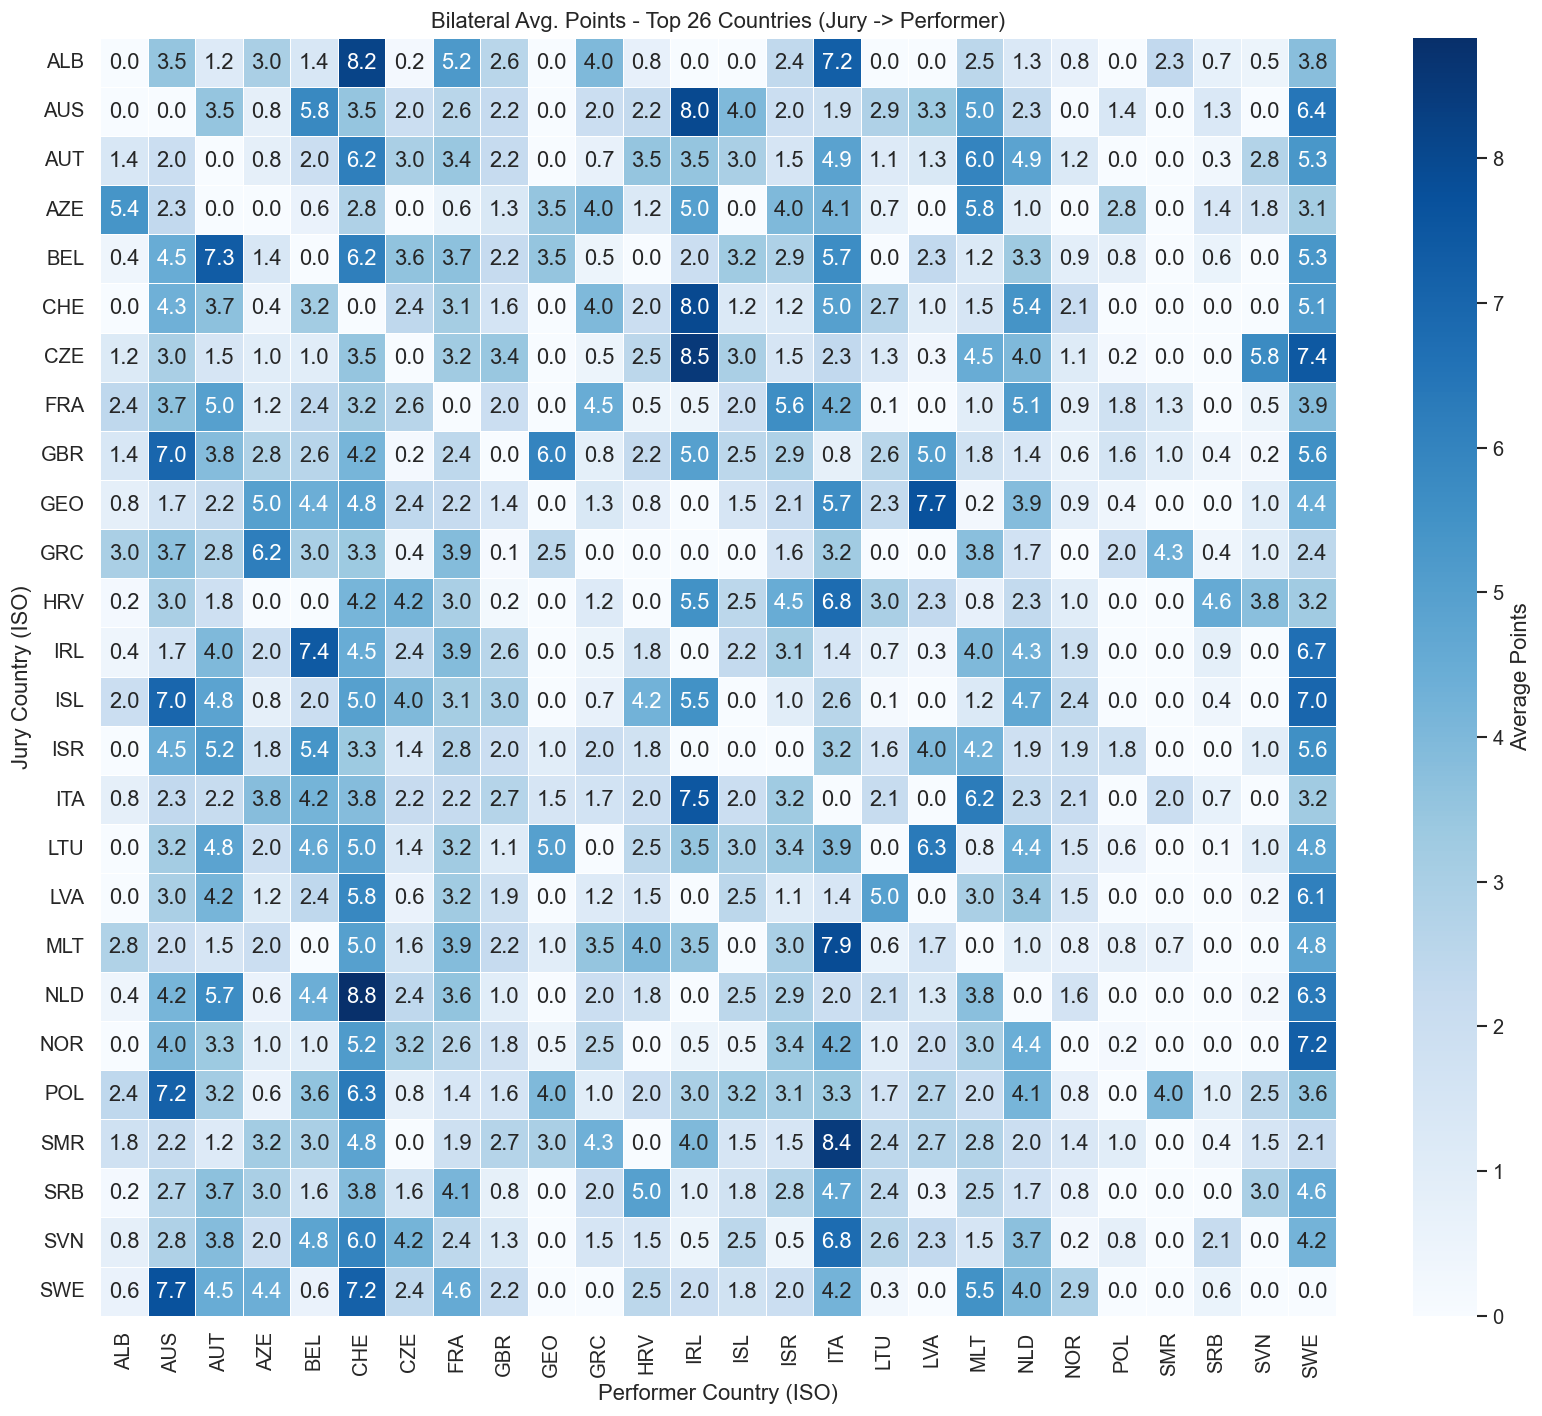

In [10]:
# heatmap of bilateral avg points (top N most active countries)
TOP_N = 26

top_countries = (
	df.groupby("jury_iso")['jury_points'].sum()
	.sort_values(ascending= False)
	.head(TOP_N)
	.index.tolist()
)

bilateral_pivot = (
	bilateral[
		bilateral['jury_iso'].isin(top_countries) &
		bilateral['performer_iso'].isin(top_countries)
	]
	.pivot(index= "jury_iso", columns= "performer_iso", values= "avg_points")
	.fillna(0)
)

fig, ax = plt.subplots(figsize= (14, 12))
sns.heatmap(
	bilateral_pivot,
	ax= ax,
	cmap= "Blues",
	linewidths= 0.3,
	annot= True,
	fmt= ".1f",
	cbar_kws= {"label": "Average Points"},
)

ax.set_title(f"Bilateral Avg. Points - Top {TOP_N} Countries (Jury -> Performer)")
ax.set_xlabel("Performer Country (ISO)")
ax.set_ylabel("Jury Country (ISO)")
plt.tight_layout()
plt.show()

In [11]:
# consistency check: how often does A give non-zero and top-3 points to B?
n_years = df['year'].nunique()
TOP_POINTS = {12, 10, 8}

consistency_all = (
	df[df['jury_points'] > 0]
	.groupby(["jury_iso", "performer_iso"])
	.size()
	.reset_index(name= "years_with_any_points")
)

consistency_top3 = (
	df[df['jury_points'].isin(TOP_POINTS)]
	.groupby(["jury_iso", "performer_iso"])
	.size()
	.reset_index(name= "years_with_top3_points")
)

# merge both
consistency = consistency_all.merge(consistency_top3, on= ["jury_iso", "performer_iso"], how= "left")
consistency['years_with_top3_points'] = consistency['years_with_top3_points'].fillna(0).astype(int)
consistency['pct_any'] = (consistency['years_with_any_points'] / n_years * 100).round(1)
consistency['pct_top3'] = (consistency['years_with_top3_points'] / n_years * 100).round(1)

consistency.sort_values("years_with_any_points", ascending= False, inplace= True)

print(f"Total years in dataset: {n_years}")
print("\nMost consistent bilateral pairs (received points in X out of Y years):")
consistency.head(15)

Total years in dataset: 9

Most consistent bilateral pairs (received points in X out of Y years):


,jury_iso,performer_iso,years_with_any_points,years_with_top3_points,pct_any,pct_top3
1294,SMR,ITA,9,6,100.0,66.7
387,DEU,SWE,9,4,100.0,44.4
422,DNK,SWE,9,3,100.0,33.3
307,CYP,ITA,9,4,100.0,44.4
523,FIN,SWE,9,7,100.0,77.8
1141,NOR,SWE,8,6,88.9,66.7
1029,MLT,ITA,8,6,88.9,66.7
788,ISL,SWE,8,4,88.9,44.4
19,ALB,ITA,8,5,88.9,55.6
444,ESP,ITA,8,3,88.9,33.3


**On the heatmap and consistency tables:**

- Sweden and Italy are the two dominant receiver countries - the consistency tables are almost entirely composed of pairs pointing to these two, confirmed visually by the heatmap's darkest columns.

- The Nordic bloc (FIN, NOR, DNK, EST, ISL, LVA, NDL) voting for Sweden and the Mediterranean bloc (SMR, MLT, ALB, CHE, SVN, CYP, ESP) voting for Italy are the two strongest and most stable voting structures in the dataset.

- San Marino -> Italy and Finland -> Sweden are the single most reliable bilateral signals - present in nearly every year and consistently in the top-3 points range.

- Greece <-> Cyprus is the clearest mutual bloc - both directions appear in the top-3 consistency table, confirming a genuine two-way relationship.

- San Marino and Malta's preference for Italy is unsurprising given their deep cultural and geographic ties - these pairs will naturally receive maximum affinity scores in feature engineering.

In [12]:
# compare average points received per jury for SWE and ITA
targets = ["SWE", "ITA"]

compare = (
	df[df["performer_iso"].isin(targets)]
	.groupby(["performer_iso", "jury_iso"])["jury_points"]
	.mean()
	.reset_index(name="avg_points_received")
	.pivot(index="jury_iso", columns="performer_iso", values="avg_points_received")
	.fillna(0)
	.round(2)
)

compare["diff (SWE - ITA)"] = (compare["SWE"] - compare["ITA"]).round(2)
compare = compare.sort_values("diff (SWE - ITA)", ascending=False)

print("Average points received from each jury (all years):")
compare

Average points received from each jury (all years):


performer_iso,ITA,SWE,diff (SWE - ITA)
jury_iso,,,
FIN,3.56,10.00,6.44
DNK,1.00,7.22,6.22
IRL,1.44,6.67,5.23
CZE,2.33,7.44,5.11
EST,2.78,7.78,5.00
GBR,0.78,5.56,4.78
LVA,1.44,6.11,4.67
AUS,1.89,6.44,4.55
ISL,2.56,7.00,4.44


**On Sweden vs Italy Comparison:**

- Sweden is clear favourite of Northern and Western Europa - FIN, DNK, IRL, CZE, EST, GBR, LVA consistently award Sweden significantly higher points than Italy.

- Italy's support is concentrated in Southern and Eastern Europe - SMR, ALB, HRV, SVN, MLT give Italy markedly higher points, confirming that Italy's consistency comes from a strong regional bloc rather than broad universal appeal.

- Spain, France, Belgium, Cyprus and Greece are efectively neutral between the two (diff ~0), suggesting their votes are driven more by yearly song quality than fixed affinity.

**Implication for Modeling:** Both Sweden and Italy are strong receivers, but their support bases are geographically distinct. A geographic proximity feature will be essential to capture this split. 

---
## 4. Stability Over Time (Year-to-Year Correlations)

**Question:** How stable are jury voting patterns from one year to the next year? High stability justifies using historical averages as a strong baseline.

In [13]:
# build a (jury_iso, performer_iso) -> points pivot per year
yearly_pivot = df.pivot_table(
	index= ["jury_iso", "performer_iso"],
	columns= "year",
	values= "jury_points",
	aggfunc= "sum",
	fill_value= 0,
)
yearly_pivot.head()

year                    2016  2017  2018  2019  2021  2022  2023  2024  2025
jury_iso performer_iso                                                      
ALB      ARM               0     7     0     0     0     4    10     8     0
         AUS              12     4     0     2     0     0     3     0     0
         AUT               0     0     0     0     0     0     0     0     7
         AZE               0     2     0     8     2     3     0     0     0
         BEL               0     0     0     0     0     2     5     0     0

In [14]:
# per-jury stability: how correlated is each jury with itself across years?
from scipy.stats import spearmanr

jury_stability = []

for jury in df['jury_iso'].unique():
	jury_df = df[df['jury_iso'] == jury].pivot_table(
		index= "performer_iso",
		columns= "year",
		values= "jury_points",
		fill_value= 0
	)

	if jury_df.shape[1] < 2:
		continue

	rhos = []
	cols = sorted(jury_df.columns)
	for y1, y2 in zip(cols[:-1], cols[1:]):
		rho, _ = spearmanr(jury_df[y1], jury_df[y2])
		rhos.append(rho)
	jury_stability.append(
		{
			"jury_iso": jury,
			"mean_rho": round(np.mean(rhos), 3)
		}
	)

stability_df = pd.DataFrame(jury_stability).sort_values("mean_rho", ascending= False)
stability_df.head(15)

,jury_iso,mean_rho
43,LUX,0.317
15,CYP,0.261
12,FRA,0.254
32,ALB,0.240
33,EST,0.227
25,BEL,0.221
38,HUN,0.217
21,DEU,0.203
30,SRB,0.194
27,HRV,0.180


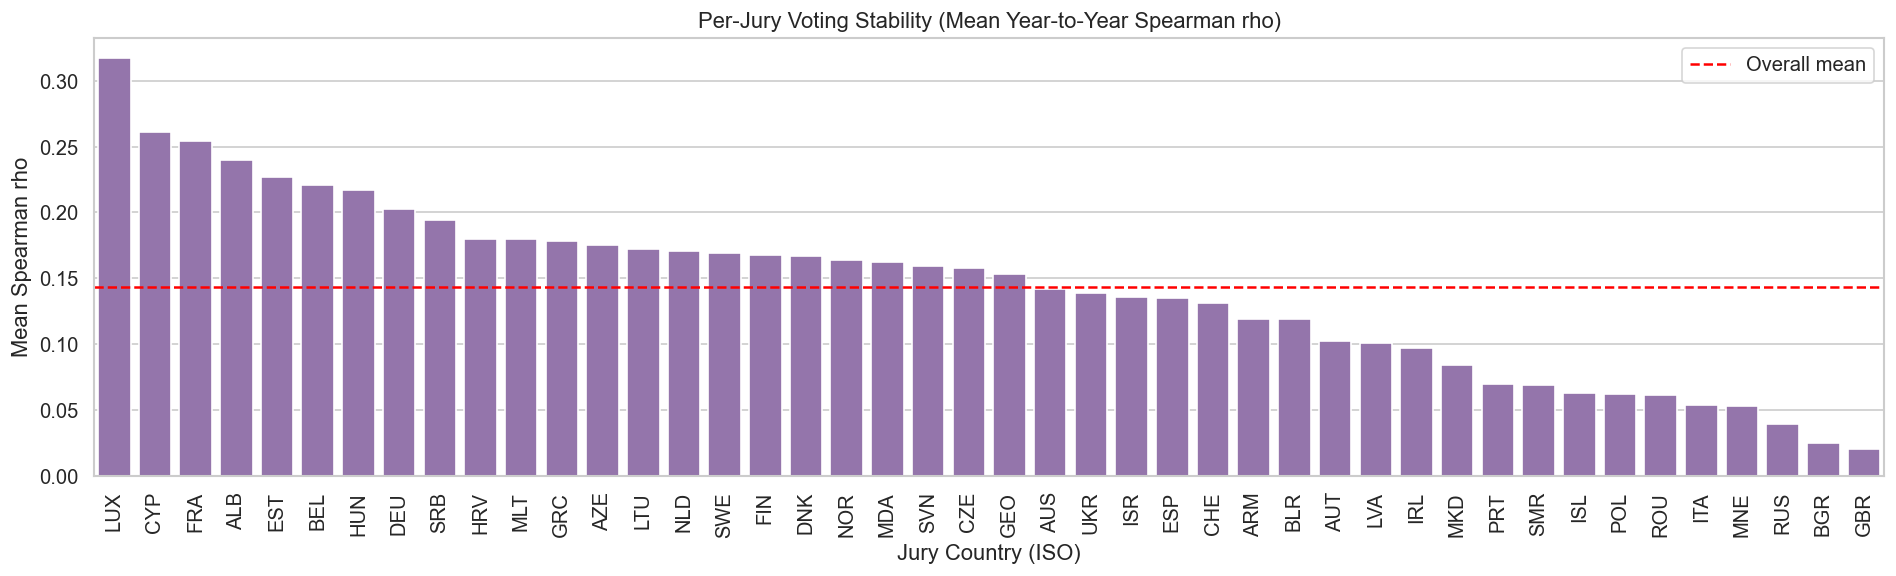

In [15]:
fig, ax = plt.subplots(figsize= (16, 5))
sns.barplot(
	data= stability_df,
	x= "jury_iso",
	y= "mean_rho",
	order= stability_df['jury_iso'],
	ax= ax,
	color= sns.color_palette("muted")[4],
)

ax.axhline(stability_df["mean_rho"].mean(), color="red", linestyle="--", label="Overall mean")
ax.set_title("Per-Jury Voting Stability (Mean Year-to-Year Spearman rho)")
ax.set_xlabel("Jury Country (ISO)")
ax.set_ylabel("Mean Spearman rho")
ax.tick_params(axis="x", rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

**Obligations:**

- Overall stability is low - even the most stable jury (LUX, rho = 0.317) has a modest correlation, meaning jury voting patterns change considerably from year to year.

- Luxembourg's high ranking is misleading - it only has data for two years (2024 and 2025), so its `mean_rho` is based on a single year pair and is not reliable.

- Cyprus (0.261) and France (0.254) are the most stable genuine juries - Cyprus' consistent preference for Greece largely explains its stability.

**Implication for Modeling:** Low but non-zero stability suggests that historical voting behavior carries a weak signal. A baseline model built purely on historical averages will have limited power, and additional features (geography, language, running order) will be needed to improve ranking accuracy.

---
## 5. Summary & Key Takeaways

| # | Finding | Implication for Modeling |
|---|---------|---------------------------|
| 1 | Performer count is stable (25-26) across all years, but jury pool has shrunk from 43 to 37 since 2018 | Earlier years have more jury samples but may be less representative of the current competition structure. |
| 2 | Jury generosity differences are negligible - all averages cluster between 2.2 and 2.4. | No jury-level normalization needed for generosity. |
| 3 | Two dominant receiver countries: Sweden (Nordic/Baltic bloc) and Italy (Mediterranean bloc). SMR->ITA and FIN->SWE are the most reliable bilateral signals. CYP<->GRC is the strongest mutual bloc. Average points alone is a poor signal without controlling for sample size. | Geographic proximity and historical affinity are the two most important features for JOB 4. Consistency (years with points) is a more reliable feature than raw average points. |
| 4 | Per-jury stability is low (rho = 0.18–0.32 for the most stable juries), suggesting voting patterns shift considerably year to year. | Historical voting behavior carries a weak signal. Additional features (geography, language, running order) will be necessary to improve ranking accuracy. |